In [4]:
!pip install segmentation_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.9 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import numpy
import torch
import zipfile

from tensorflow import keras
import tensorflow as tf
import segmentation_models as sm
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger



Segmentation Models: using `tf.keras` framework.


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [7]:
batch_size = 16
lr = 0.0001
epochs = 20
IMG_SIZE = 256

img_folder_path = "/content/drive/MyDrive/Colab Notebooks/segmentation_full_body_mads/images"
mask_folder_path = "/content/drive/MyDrive/Colab Notebooks/segmentation_full_body_mads/masks"

In [8]:
os.environ["PYTHONHASHSEED"] = str(42)
np.random.seed(42)
tf.random.set_seed(42)

In [9]:
dataset_path = os.path.join("/content/drive/MyDrive/Colab Notebooks", "segmentation_full_body_mads")
files_dir = os.path.join("/content/drive/MyDrive/Colab Notebooks", "files", "segmentation_full_body_mads")
model_file = os.path.join(files_dir, "sm-unet_body.h5")
log_file = os.path.join(files_dir, "log-sm-unet_body.csv")

In [8]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [9]:
create_dir(files_dir)

# Đọc dữ liệu

In [10]:
def read_and_process_images(img_folder_path, mask_folder_path, img_size):
    img_files = sorted(os.listdir(img_folder_path))
    mask_files = sorted(os.listdir(mask_folder_path))
    num_images = len(img_files)

    image_data = np.empty((num_images, img_size, img_size, 3), dtype=np.uint8)
    mask_data = np.empty((num_images, img_size, img_size), dtype=np.uint8)

    for index, (img_file, mask_file) in enumerate(zip(img_files, mask_files)):
        img_path = os.path.join(img_folder_path, img_file)
        mask_path = os.path.join(mask_folder_path, mask_file)

        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (img_size, img_size))
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image_data[index] = img

        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (img_size, img_size))
        mask_data[index] = mask

    return image_data, mask_data



In [11]:
image_data, mask_data = read_and_process_images(img_folder_path, mask_folder_path, IMG_SIZE)

print('image shape:', image_data.shape)
print('mask shape:', mask_data.shape)

image shape: (1192, 256, 256, 3)
mask shape: (1192, 256, 256)


In [12]:
classes = ['body']
n_classes = len(classes)

# Hiển thị dữ liệu đầu vào sau khi xử lý

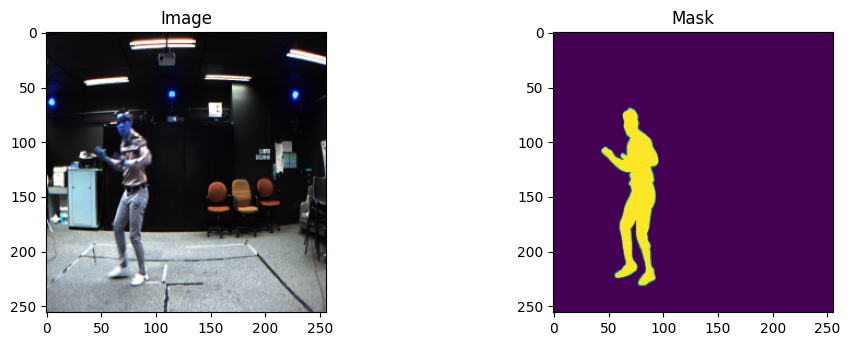

In [13]:
import random

img_number = random.randint(0, len(image_data)-1)

img = image_data[img_number]
mask = mask_data[img_number]

plt.figure(figsize=(12,8))
plt.subplot(221)
plt.title('Image')
plt.imshow(img)
plt.subplot(222)
plt.title('Mask')
plt.imshow(mask)
plt.show()

# Tiền xử lý dữ liệu + Define model dựa trên segmentation_models framework

In [14]:
mask_data_binary = np.where(mask_data > 0, 1, 0)
mask_data_binary = mask_data_binary[..., np.newaxis]  # Thêm một chiều cuối cùng để khớp với kích thước của image_data

mask_data_binary.shape

(1192, 256, 256, 1)

In [15]:
sm.set_framework('tf.keras')
sm.framework()

BACKBONE = 'resnet18' #iou 91%
# BACKBONE = 'resnet34' #iou 81%

preprocess_input = sm.get_preprocessing(BACKBONE)

X = image_data
Y = mask_data_binary

x_train, x_val, y_train, y_val = train_test_split(X,Y,test_size=0.2,random_state=47)

x_train = preprocess_input(x_train)
y_train = preprocess_input(y_train)

y_train = y_train.astype('float32')
y_val = y_val.astype('float32')


# Fit model with train_test_split

In [17]:
# define network parameters
n_classes = 1 if len(classes) == 1 else (len(classes) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

model = sm.Unet(BACKBONE,encoder_weights='imagenet',classes= n_classes, activation='sigmoid')


optim = keras.optimizers.Adam(lr)

dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
model.compile(optim, total_loss, metrics)

# ---------------------------------------------------------------------------------------------------------
# model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score, sm.metrics.FScore()])

print(model.summary())

44920640/44920640 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                           

In [17]:
callbacks = [
        ModelCheckpoint(model_file, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=4),
        CSVLogger(log_file),
        EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=False)
]

In [18]:
history=model.fit(x_train,
          y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, y_val),
          callbacks=callbacks
          )

Epoch 1/20
60/60 [==============================] - ETA: 0s - loss: 0.9879 - iou_score: 0.1981 - f1-score: 0.3128
Epoch 1: val_loss improved from inf to 0.98166, saving model to /content/drive/MyDrive/Colab Notebooks/files/segmentation_full_body_mads/sm-unet_body.h5
60/60 [==============================] - 73s 501ms/step - loss: 0.9879 - iou_score: 0.1981 - f1-score: 0.3128 - val_loss: 0.9817 - val_iou_score: 0.0808 - val_f1-score: 0.1495 - lr: 1.0000e-04
Epoch 2/20
60/60 [==============================] - ETA: 0s - loss: 0.7949 - iou_score: 0.6101 - f1-score: 0.7513
Epoch 2: val_loss improved from 0.98166 to 0.88150, saving model to /content/drive/MyDrive/Colab Notebooks/files/segmentation_full_body_mads/sm-unet_body.h5
60/60 [==============================] - 14s 230ms/step - loss: 0.7949 - iou_score: 0.6101 - f1-score: 0.7513 - val_loss: 0.8815 - val_iou_score: 0.4163 - val_f1-score: 0.5877 - lr: 1.0000e-04
Epoch 3/20
60/60 [==============================] - ETA: 0s - loss: 0.6921 -

In [19]:
accuracy = model.evaluate(x_val, y_val)

8/8 [==============================] - 5s 105ms/step - loss: 0.0804 - iou_score: 0.9103 - f1-score: 0.9530


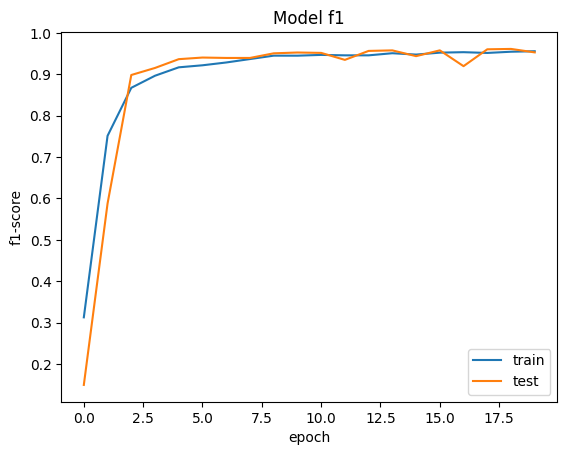

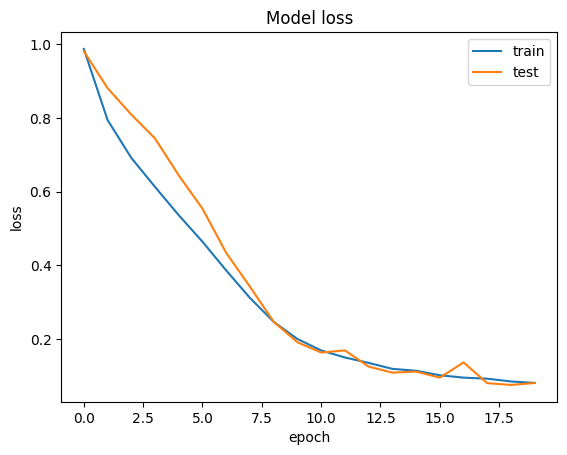

In [21]:
# summarize history for accuracy
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('Model f1')
plt.ylabel('f1-score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

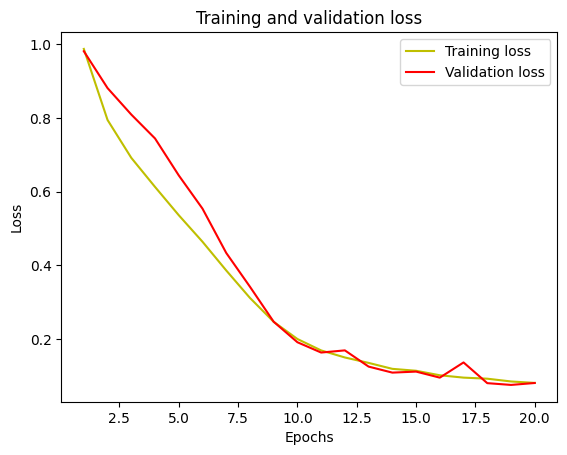

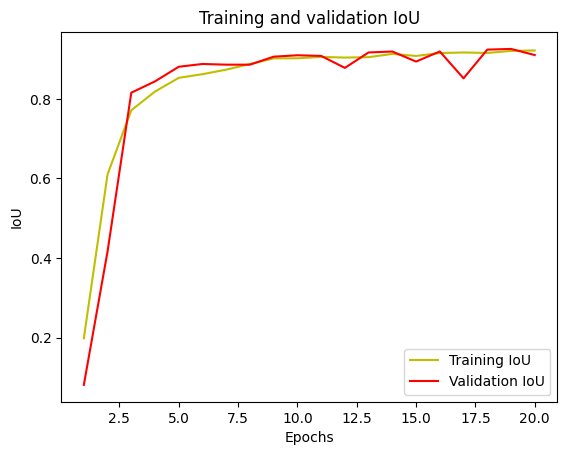

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()


In [24]:
preds = model.predict(x_val)

8/8 [==============================] - 76s 9s/step


In [25]:
a = np.zeros((256,256,1))
a[preds[0]>0.5] = 1

In [26]:
preds[0].max()

1.0

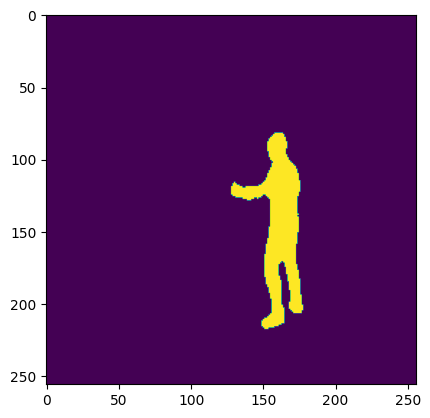

In [59]:
plt.imshow(a)

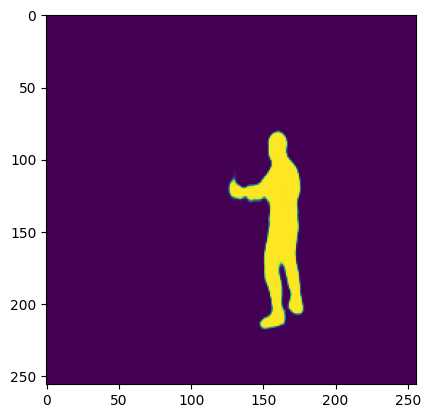

In [113]:
plt.imshow(preds[0])


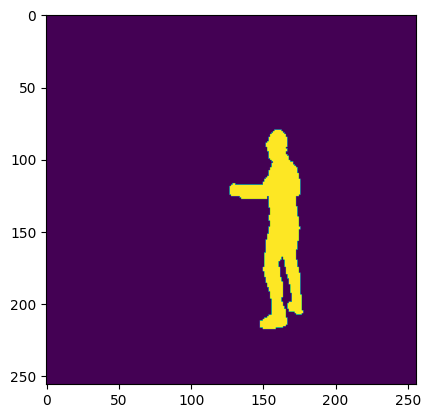

In [114]:
plt.imshow(y_val[0])


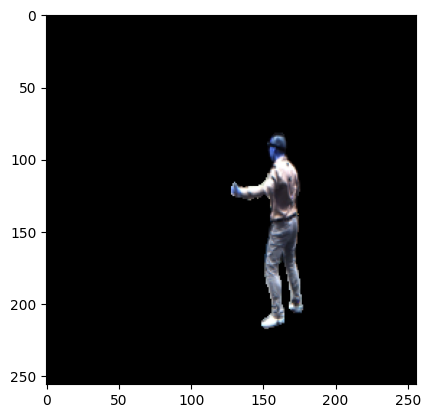

In [27]:
img_show = x_val[0]*a / 255.
plt.imshow(img_show)

In [18]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/files/segmentation_full_body_mads/sm-unet_body.h5')

In [19]:
preds=model.predict(x_val)

8/8 [==============================] - 71s 9s/step


In [20]:
def create_mask(predictions,input_shape=(256,256,1)):
    mask = np.zeros(input_shape)
    mask[predictions>0.5] = 1
    return mask

In [28]:
def plot_results_for_one_sample(sample_index):
    mask = create_mask(preds[sample_index])
    f = plt.figure(figsize=(20,20))
    f.add_subplot(1,4,1)
    plt.title('Input image')
    plt.imshow(x_val[sample_index])
    f.add_subplot(1,4,2)
    plt.title('Real mask')
    plt.imshow(y_val[sample_index])
    f.add_subplot(1,4,3)
    plt.title('Predicted mask')
    plt.imshow(mask)
    f.add_subplot(1,4,4)
    plt.title("Mask + image")
    plt.imshow(x_val[sample_index]*mask / 255.)

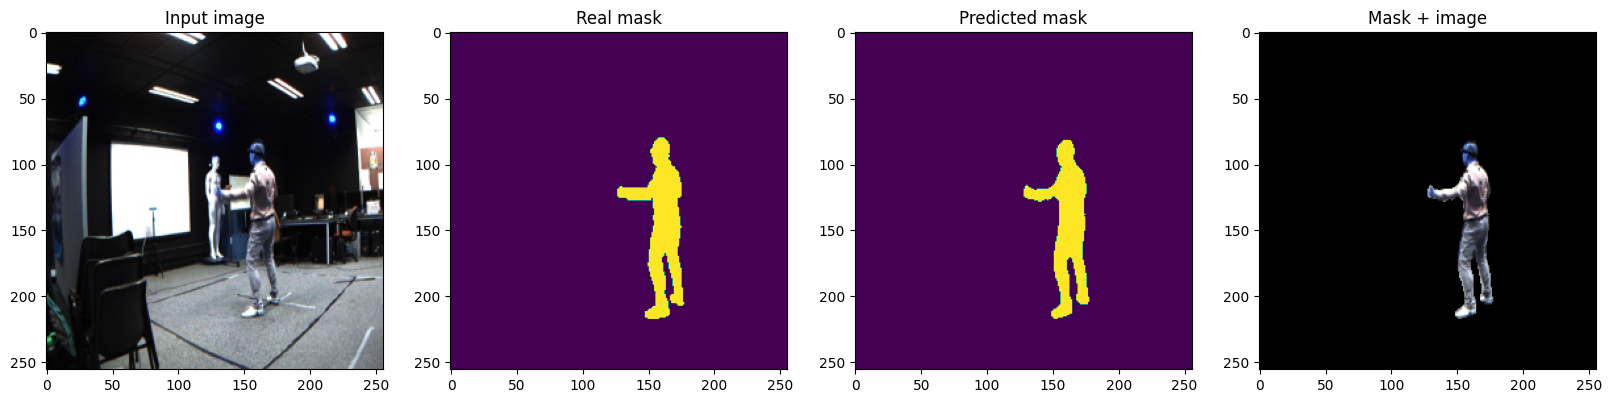

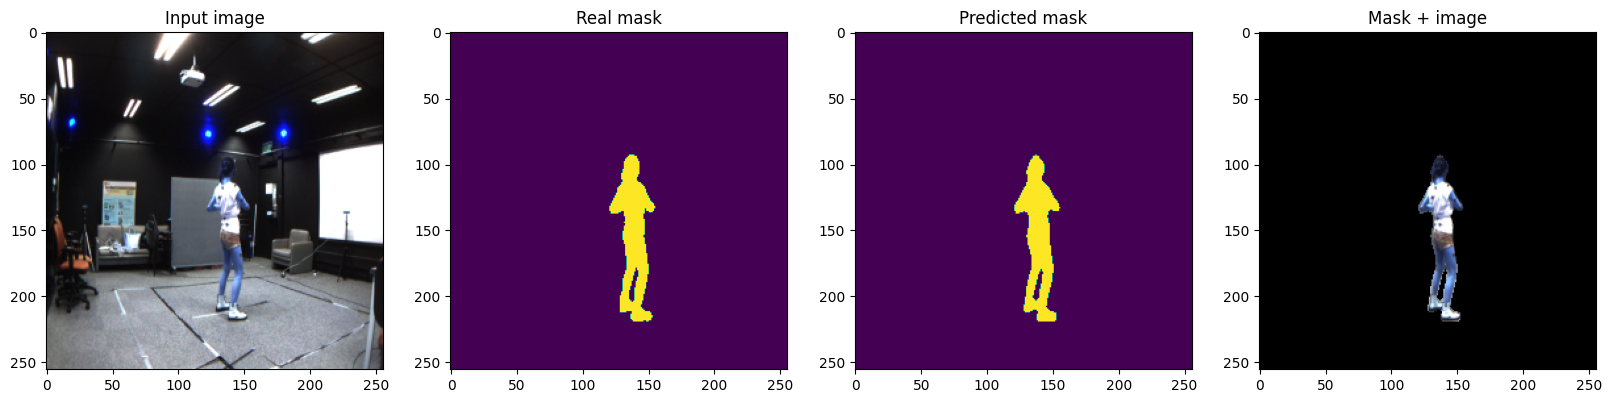

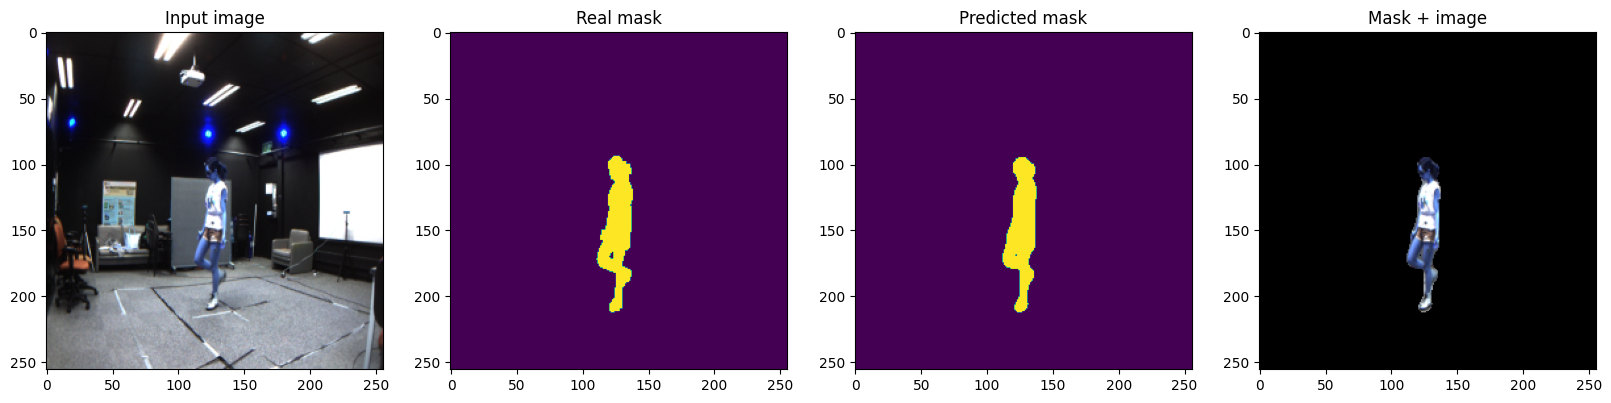

In [29]:
for idx in range(3):
    plot_results_for_one_sample(idx)
    plt.show()
